In [2]:
import os

os.environ['KERAS_BACKEND'] = "torch"
import keras

In [3]:
from keras import datasets

(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)


X_train shape:  (60000, 28, 28)
y_train shape:  (60000,)
X_test shape:  (10000, 28, 28)
y_test shape:  (10000,)


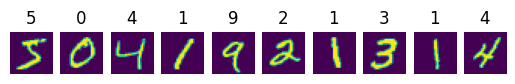

In [5]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    plt.title(y_train[i])
    plt.axis("off")

In [6]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

print("X-train shape: ", X_train.shape)
print("X-test shape: ", X_test.shape)

X-train shape:  (60000, 784)
X-test shape:  (10000, 784)


In [7]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [8]:
import numpy as np

def generatePairs(X, y):
    X_pairs = []
    y_pairs = []
    
    for i in range(len(X)):
        digit = y[i]
        
        # Select a positive pair (same class)
        positive_digit_pair = np.random.choice(np.where(y == digit)[0])
        X_pairs.append([X[i], X[positive_digit_pair]])
        y_pairs.append(0)
        
        # Select a negative pair (different class)
        negative_digit_pair = np.random.choice(np.where(y != digit)[0])
        X_pairs.append([X[i], X[negative_digit_pair]])
        y_pairs.append(1)
        
    # Shuffle the pairs
    indices = np.arange(len(X_pairs))
    np.random.shuffle(indices)
    
    return np.array(X_pairs)[indices], np.array(y_pairs)[indices]


In [9]:
X_train_pairs, y_train_pairs = generatePairs(X_train, y_train)
X_test_pairs, y_test_pairs = generatePairs(X_test, y_test)
print('X-train-pairs: ', X_train_pairs.shape)
print('X-test-pairs: ', X_test_pairs.shape)


X-train-pairs:  (120000, 2, 784)
X-test-pairs:  (20000, 2, 784)


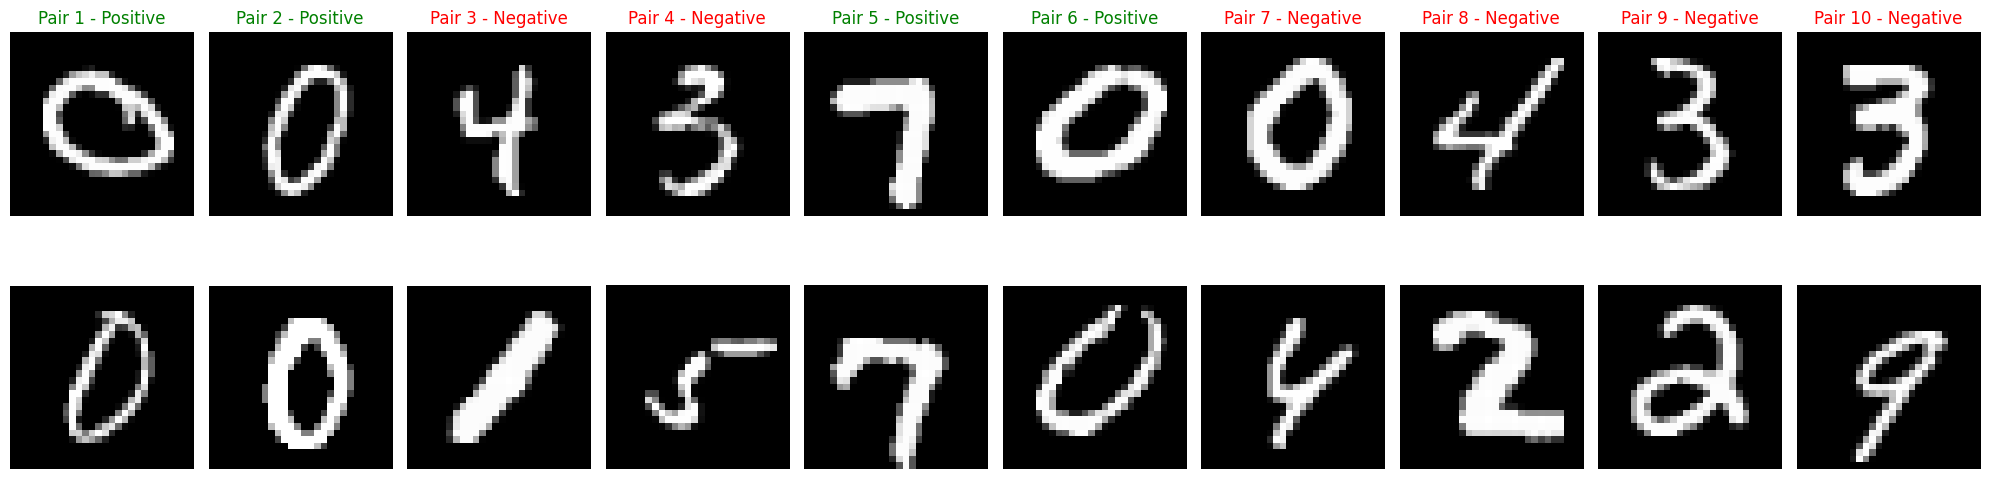

In [10]:
import matplotlib.pyplot as plt

def displayImages(X_test_pairs, y_test_pairs, correct=None):
    n = 10  # Number of pairs to display
    plt.figure(figsize=(20, 6))
    
    for i in range(n):
        # Reshape the images to 28x28 for displaying
        image1 = X_test_pairs[i][0].reshape(28, 28)
        image2 = X_test_pairs[i][1].reshape(28, 28)
        label = int(y_test_pairs[i])
        text = "Positive" if label == 0 else "Negative"
        color = "green" if label == 0 else "red"
        
        # Plot the first image
        plt.subplot(2, n, i+1)
        plt.imshow(image1, cmap='gray')
        plt.title(f"Pair {i+1} - {text}", color=color)
        plt.axis('off')

        # Plot the second image
        plt.subplot(2, n, i+n+1)
        plt.imshow(image2, cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

    
displayImages(X_test_pairs, y_test_pairs)


In [11]:
from keras import Input

input1 = Input(shape=(784,))
input2 = Input(shape=(784,))

In [12]:
from keras.layers import Dense
from keras.models import Sequential

network = Sequential(
    [
        Input(shape=(784,)),
        Dense(512, activation="relu"),
        Dense(256, activation="relu"),
        Dense(128, activation=None)
    ]
)

In [13]:
twin1 = network(input1)
twin2 = network(input2)

In [14]:
from keras.layers import Lambda
from keras.ops import norm

def euclidean_distance(twins):
    twin1_output, twin2_output = twins
    return norm(twin1_output - twin2_output, axis=1, keepdims=True)

distance = Lambda(euclidean_distance)([twin1, twin2])

In [15]:
from keras import Model

model = Model(inputs=[input1, input2], outputs=distance)

In [31]:
import torch

def contrastive_loss(y_true, d):
    margin = 1.0
    loss = (1 - y_true) * torch.square(d) + y_true * torch.square(torch.clamp(margin - d, min=0))
    return torch.mean(loss)


In [32]:
from keras.metrics import binary_accuracy
model.compile(loss=contrastive_loss, optimizer="adam", metrics=[binary_accuracy])

In [34]:
history = model.fit(
    x = [X_train_pairs[:, 0], X_train_pairs[:, 1]],
    y = y_train_pairs[:],
    validation_data = ([X_test_pairs[:, 0], X_test_pairs[:, 1]],y_test_pairs[:]),
    batch_size = 4,
    epochs = 5
)

Epoch 1/5
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 329s 11ms/step - binary_accuracy: 0.9634 - loss: 0.0396 - val_binary_accuracy: 0.9614 - val_loss: 0.0398
Epoch 2/5
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 700s 23ms/step - binary_accuracy: 0.9735 - loss: 0.0309 - val_binary_accuracy: 0.9587 - val_loss: 0.0407
Epoch 3/5
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 717s 24ms/step - binary_accuracy: 0.9785 - loss: 0.0266 - val_binary_accuracy: 0.9609 - val_loss: 0.0399
Epoch 4/5
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 639s 21ms/step - binary_accuracy: 0.9815 - loss: 0.0238 - val_binary_accuracy: 0.9563 - val_loss: 0.0408
Epoch 5/5
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 609s 20ms/step - binary_accuracy: 0.9836 - loss: 0.0215 - val_binary_accuracy: 0.9612 - val_loss: 0.0360


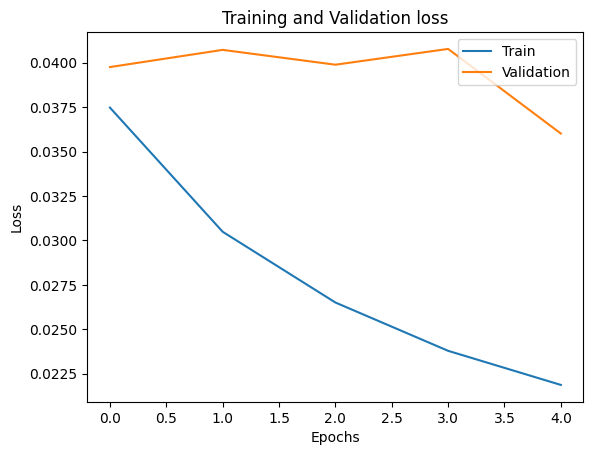

In [37]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper right")

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


C:\Users\ahmed\AppData\Local\Temp\ipykernel_24936\2614160761.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(y_test_pairs[i])


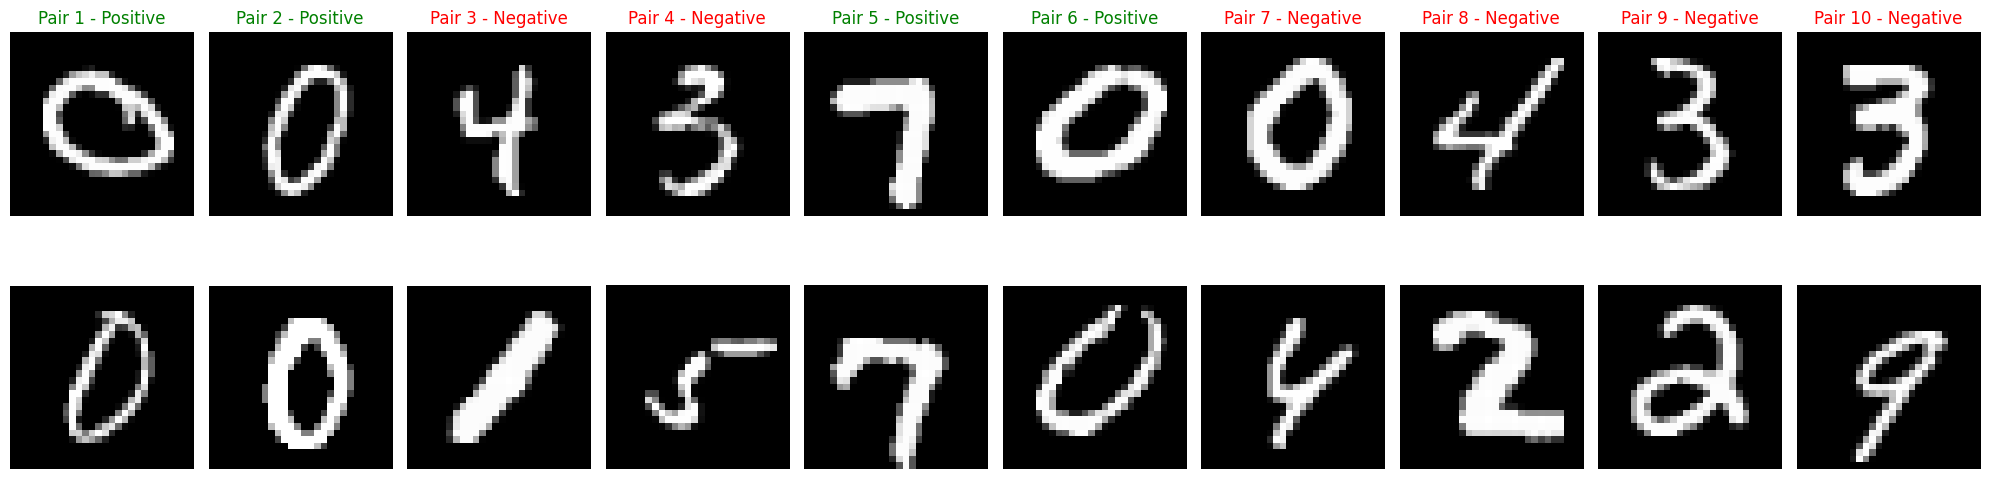

In [38]:
predictions = model.predict([X_test_pairs[:, 0], X_test_pairs[:, 1]]) >= 0.5
displayImages(X_test_pairs, predictions)

In [42]:
accuracy = keras.metrics.BinaryAccuracy()
accuracy.update_state(y_test_pairs, predictions.astype(int))
print(f"Accuracy: {100 * accuracy.result().numpy():.2f}%")

Accuracy: 96.12%


In [43]:
model.layers

[<InputLayer name=input_layer, built=True>,
 <InputLayer name=input_layer_1, built=True>,
 <Sequential name=sequential, built=True>,
 <Lambda name=lambda, built=True>]

In [46]:
embedding_model = model.layers[2]

In [49]:
index1 = np.random.choice(np.where(y_test == 3)[0])
index2 = np.random.choice(np.where(y_test == 3)[0])
index3 = np.random.choice(np.where(y_test == 7)[0])
index1, index2, index3

(1495, 5780, 1347)

In [53]:
embeddings1 = embedding_model.predict(X_test[index1].reshape(1, -1))
embeddings2 = embedding_model.predict(X_test[index2].reshape(1, -1))
embeddings3 = embedding_model.predict(X_test[index3].reshape(1, -1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [55]:
norm(embeddings1 - embeddings3).numpy()

array(0.9727418, dtype=float32)

In [57]:
norm(embeddings1 - embeddings2).numpy()

array(0.30210325, dtype=float32)